# Esercitazione 4

In [12]:
#librerie necessarie

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

## Introduzione

- Le cartelle contengono tutti i codici scritti per la realizzazione dell'esercitazione.

- Nella cartella sono già contenuti tutti i risultati di output suddivisi a seconda della fase analizzata. Questi ultimi sono quelli analizzati ed esposti in questo notebook e non è quindi necessaria la ricompilazione e la riesecuzione dei codici; nel caso si volessero rieffettuare le simulazioni è necessario eseguire il comando "make clean" seguito da "./clean.sh" così da eliminare i file di output per non sovrascriverli successivamente. Dopodichè digitare "make run" da terminale all'interno di ognuna delle cartelle delle diverse fasi così da compilare il programma e infine eseguirlo con il comando "./nomedelfileseguibile"

- Di seguito sono riportati esclusivamente i risultati dell'esercizio 04.3 poichè i codici per ottenerli comprendono tutti i miglioramenti al codice richiesti nei punti precedenti.

## Es 04.4

Sono state effettuate simulazioni di Dinamica Molecolare (MD) nell'ensamble microcanonico (NVE) di un sistema composto da 108 particelle racchiuse in un box dotato di Condizioni Periodiche al Contorno (PBC) utilizzando l'algoritmo di Verlet per integrazione numerica delle equazioni del moto e il modello di Lennard-Jones per il potenziale. L'elemento preso in considerazione è Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni termodinamiche:

- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c^\star = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c^\star = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c^\star = 5.0$)

dove $^\star$ indica le grandezze in unità ridotte.

Utilizzando le unità ridotte per un modello di Lennard-Jones, cioè esprimendo tutte le grandezza in unità di lunghezza di $\sigma$, unità di energia $\epsilon$ ed unità di massa $m$, grazie alla legge degli stati corrispondenti è possibile effettuare una sola simulazione per i sistemi considerati; i risultati ottenuti avranno infatti gli stessi andamenti ma possideranno valori diversi quando trasformati nelle unità del Sistema Internazionale.

Il codice implementato prevede la possibilità di introdurre nel sistema, qualora lo si desiderasse, le correzioni di coda per l'energia potenziale e il viriale ed analizzare i valori istantanei delle grandezze fisiche prese in considerazione.

La prima fase della simulazione prevede l'equilibrazione del sistema: l'algoritmo di Verlet per ottenere le posizioni ad istanti di tempo successivi ($\vec{r}(t+dt)$) utilizza quelle al passo al tempo t ($\vec{r}(t)$) e quelle al passo precedente ($\vec{r}(t-dt)$). Di conseguenza è necessario fornire una configurazione di input iniziale ($\vec{r}(t)$) e delle velocità iniziali con le quali ottenere $\vec{r}(t-dt)$. 

Il sistema inizialmente si trova fuori dall'equilibrio poichè la configurazione iniziale scelta è quella di un reticolo FCC mentre le velocità sono distribute uniformemente. Per permettere al sistema di raggiungere l'equilibrio è stato scelto di lasciar evolvere il sistema a partire da una temperatura iniziale scelta a seconda della fase analizzata finchè questa non raggiunga la temperatura desiderata ($T_{target}$) a cui effettuare la simulazione. Viene scelto un certo numero di passi necessari per la termalizzazione in ognuno dei quali viene fatto evolvere il sistema attraverso l'algoritmo di Verlet. Siccome attraverso questo algoritmo il sistema evolve lentamente, cioè le particelle si spostano di piccoli $\delta x$ ad ogni passo , è stato scelto di calcolare le velocità e quindi la temperatura solo ogni 20 passi; Ottenute queste informazioni si è ricavato il fattore di scala con cui riscalare le velocità.

Di seguito è riportata l'evoluzione della temperatura per ognuna delle fasi durante l'equilibrazione.

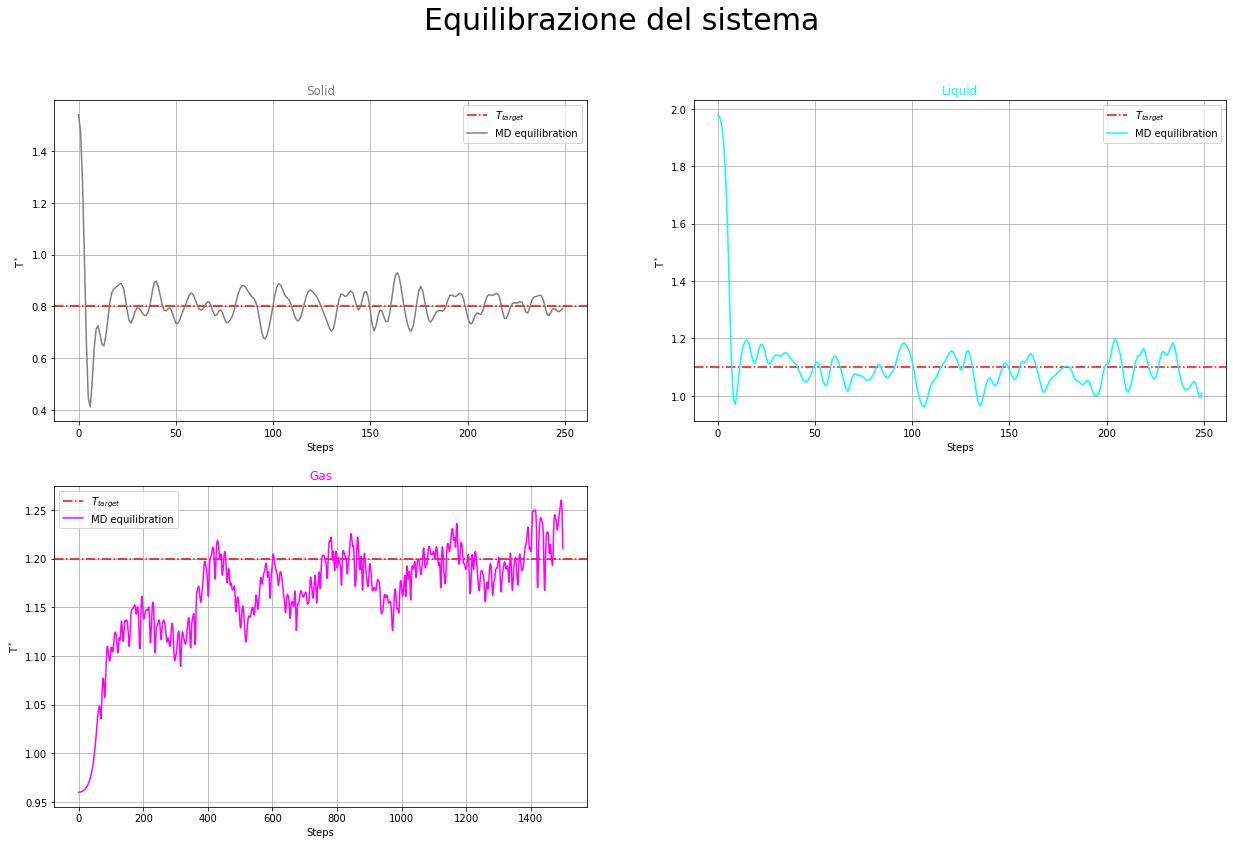

In [13]:

plt.figure(figsize=(21,13))
plt.suptitle('Equilibrazione del sistema',fontsize=30)

plt.subplot(2,2,1)
T = np.loadtxt('4/solido/output_restart.out', usecols=(0), delimiter=' ', unpack='true')
plt.axhline(y=0.8,linestyle='-.',color = 'red',label = r'$T_{target}$')
plt.plot(T,label = 'MD equilibration', color = 'gray')
plt.title("Solid",color = 'gray')
plt.ylabel(r'T$^*$')
plt.xlabel(r'Steps')
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
T = np.loadtxt('4/liquido/output_restart.out', usecols=(0), delimiter=' ', unpack='true')
plt.axhline(y=1.1,linestyle='-.',color = 'red',label = r'$T_{target}$')
plt.plot(T,label = 'MD equilibration', color = 'cyan')
plt.title("Liquid",color = 'cyan')
plt.ylabel(r'T$^*$')
plt.xlabel(r'Steps')
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
T = np.loadtxt('4/gas/output_restart.out', usecols=(0), delimiter=' ', unpack='true')
plt.axhline(y=1.2,linestyle='-.',color = 'red',label = r'$T_{target}$')
plt.plot(T,label = 'MD equilibration', color = 'magenta')
plt.ylabel(r'T$^*$')
plt.xlabel(r'Steps')
plt.title("Gas",color = 'magenta')
plt.legend()
plt.grid(True)
plt.show()


Come si può osservare nei grafici la fase solida e quella liquida raggiungono la temperatura designata per la simulazione in un numero molto basso di steps rispetto alla fase gassosa, comportamento imputabile al fatto che le consifurazione di partenza è quella di un reticolo FCC; inoltre è possibile affermare che solido e liquido hanno termalizzato meglio rispetto alla gas in quanto le loro oscillazioni di temperatura attorno a quella desiderata sono più contenute rispetto a quelle del gas.

La fase di equilibrazione è seguita dalla vera e propria simulazione in cui vengono misurate istantaneamente i valori (ogni 10 steps) dell'energia totale per particella $E/N$, dell'energia potenziale per particella $U/N$, dell'energia cinetica per particella $K/N$ e della temperatura $T$ che successivamente sono analizzati con il metodo del data blocking. Sono stati effettuati 1000 steps dell'algoritmo per ognuno dei 100 blocchi considerati.

Di seguito sono riportati i grafici dei valori medi delle grandezze fisiche sopracitate con alcune considerazioni.

In [14]:
#Conversioni necessarie per ottenere i grafici in unità del Sistema Internazionale

Kb = 1.38E-23             #costante di Boltzmann
sigma = 0.34*(10**(-9))   #Unità di lunghezza in metri
e_Kb = 120.               #e/Kb     
e = (e_Kb*Kb)             #Energia in J
p = e/(sigma**3)          #Pressione in Pa

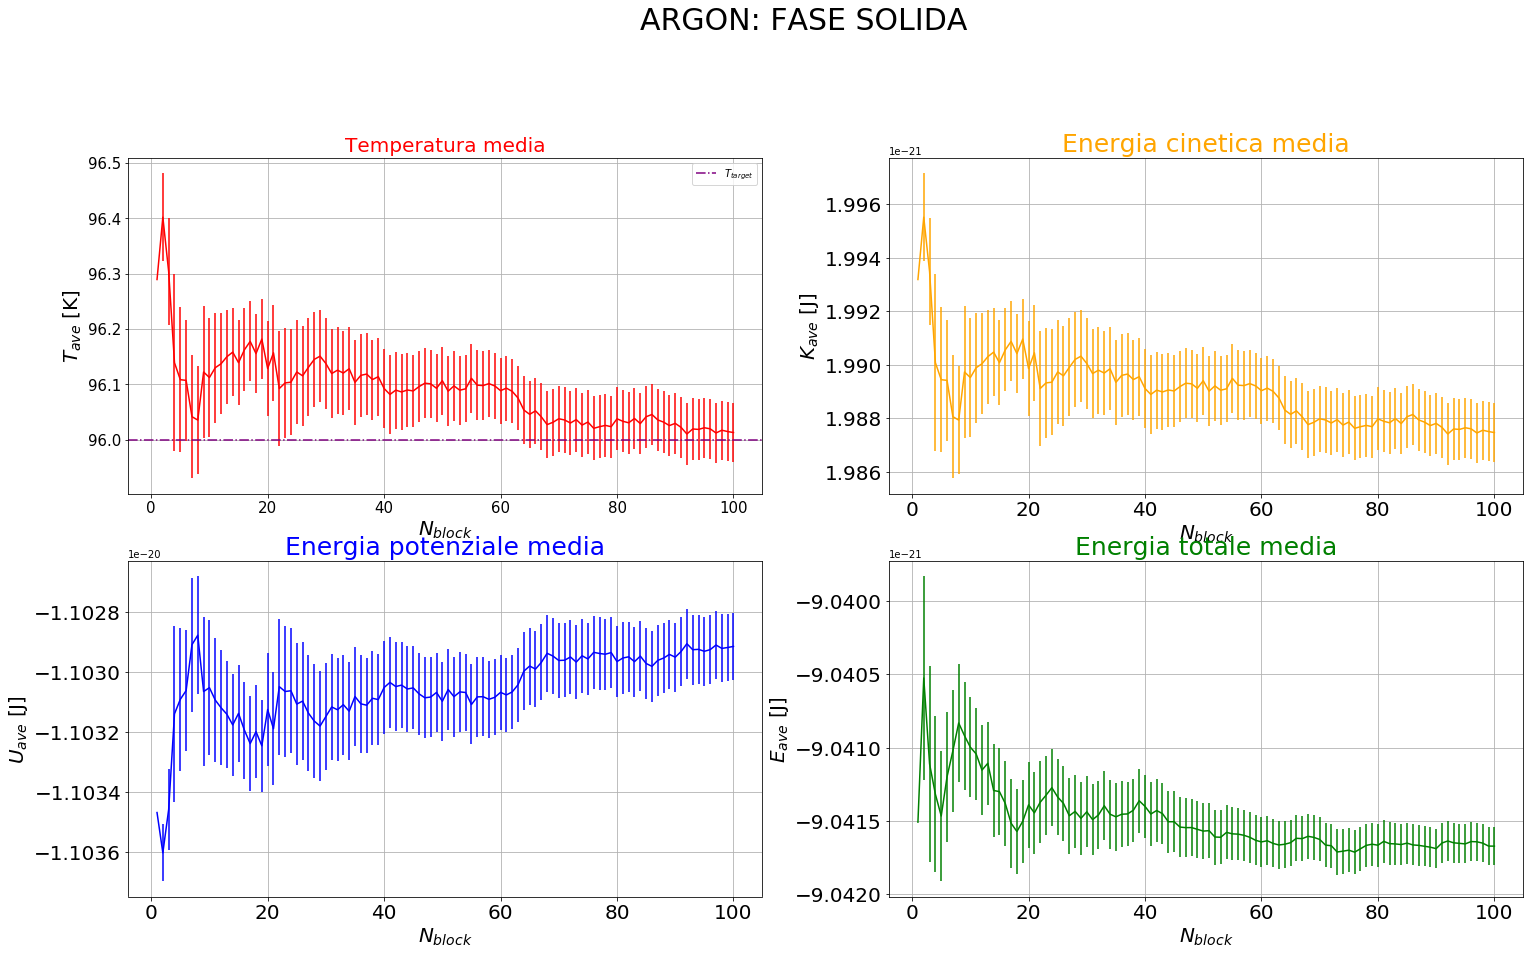

In [23]:
plt.figure(figsize=(25,21))
plt.suptitle('ARGON: FASE SOLIDA',fontsize=30)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('4/solido/media_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20,color='red')
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.axhline(y=e_Kb*0.8,linestyle='-.',color = 'purple',label = r'$T_{target}$')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$T_{ave}$ [K]', fontsize = 20)
plt.grid(True)
plt.legend()

plt.subplot(3,2,2)

N, r, error = np.loadtxt('4/solido/media_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=25,color='orange')
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$K_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('4/solido/media_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=25,color='blue')
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$U_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('4/solido/media_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=25,color ='green')
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$E_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)


plt.show()

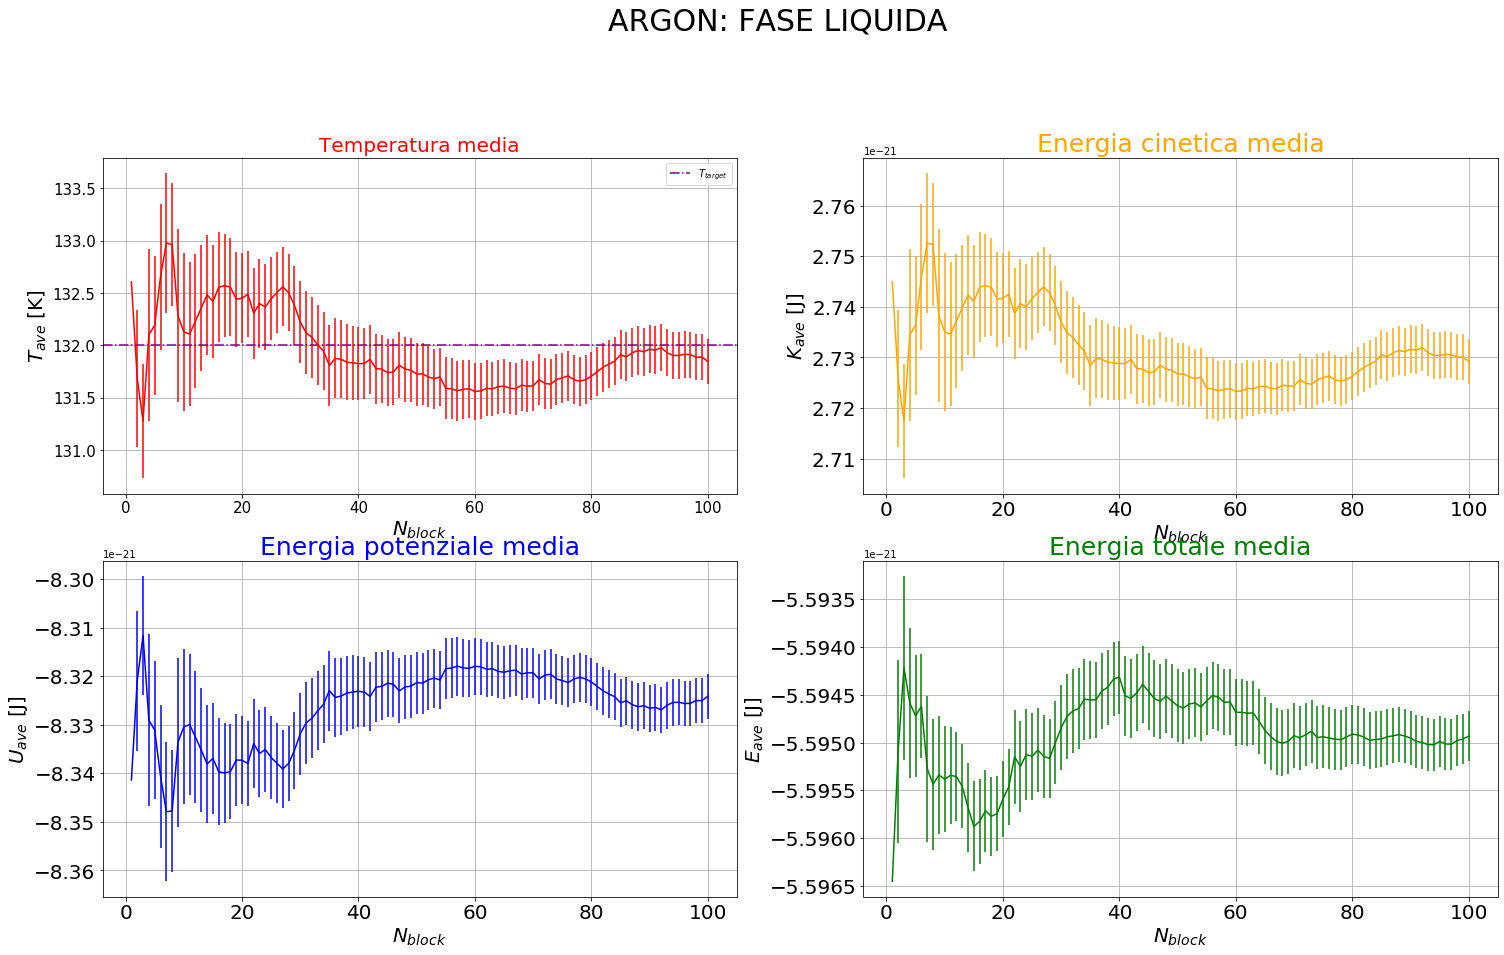

In [22]:
plt.figure(figsize=(25,21))
plt.suptitle('ARGON: FASE LIQUIDA',fontsize=30)

plt.subplot(3,2,1)

N, r, error = np.loadtxt('4/liquido/media_temp.out', usecols=(0,1,2), unpack='true')
plt.title("Temperatura media",fontsize=20,color='red')
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.axhline(y=e_Kb*1.1,linestyle='-.',color = 'purple',label = r'$T_{target}$')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$T_{ave}$ [K]', fontsize = 20)
plt.grid(True)
plt.legend()

plt.subplot(3,2,2)

N, r, error = np.loadtxt('4/liquido/media_ekin.out', usecols=(0,1,2), unpack='true')
plt.title("Energia cinetica media",fontsize=25,color='orange')
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$K_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)

plt.subplot(3,2,3)

N, r, error = np.loadtxt('4/liquido/media_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=25,color='blue')
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$U_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)


plt.subplot(3,2,4)

N, r, error = np.loadtxt('4/liquido/media_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=25,color ='green')
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$E_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)


plt.show()

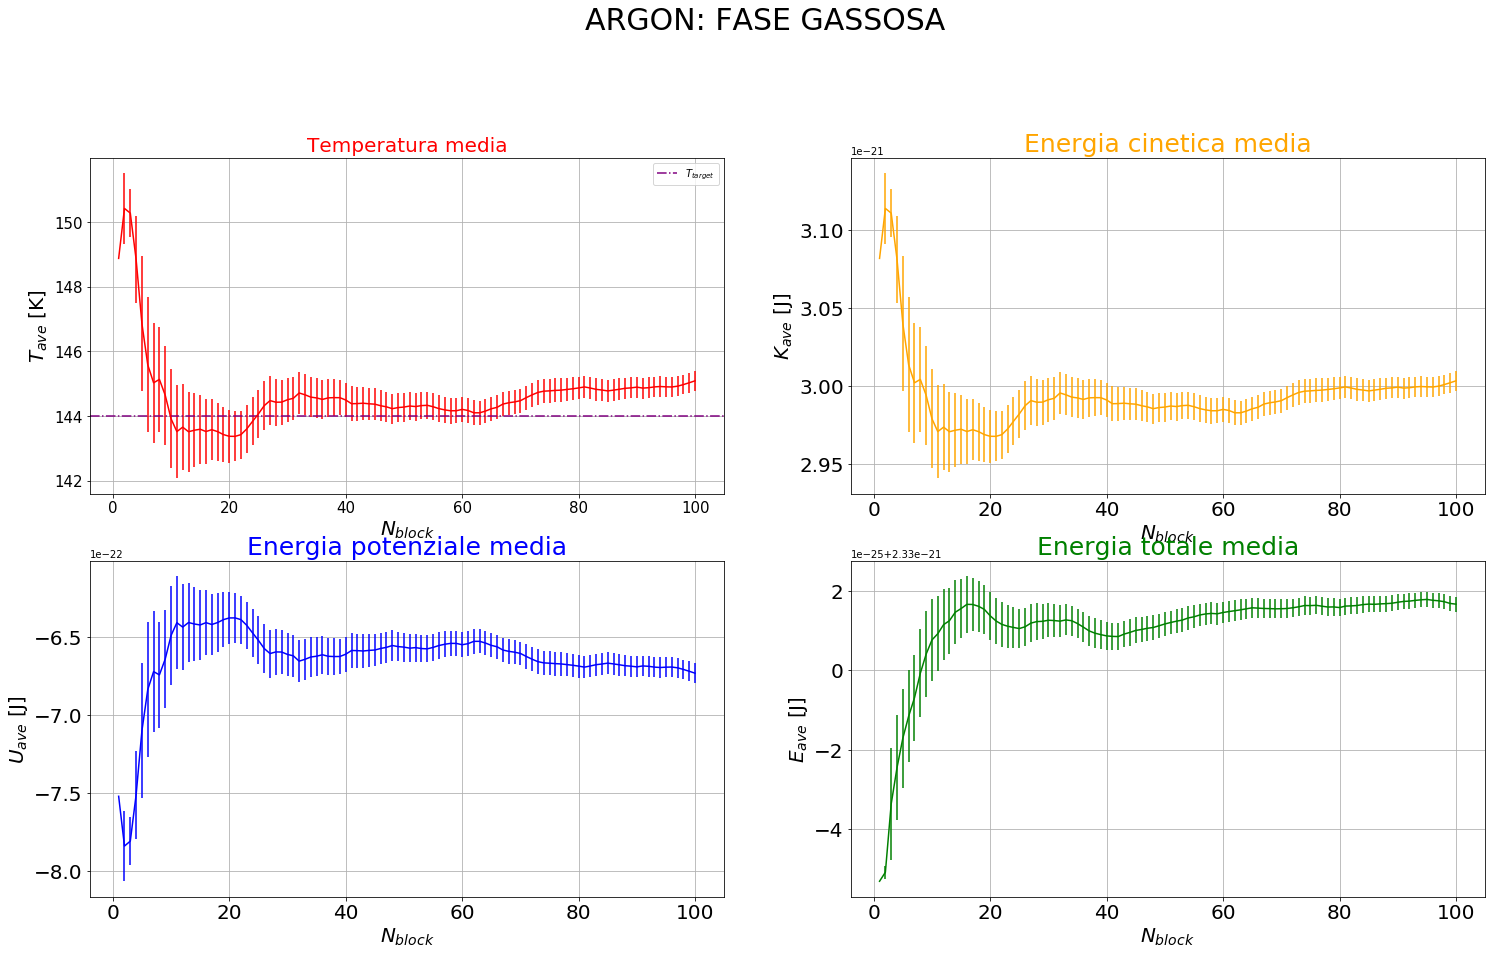

In [24]:
plt.figure(figsize=(25,21))
plt.suptitle('ARGON: FASE GASSOSA',fontsize=30)

plt.subplot(3,2,1)
N, r, error = np.loadtxt('4/gas/media_temp.out', unpack='true')
plt.title("Temperatura media",fontsize=20,color='red')
plt.errorbar(N,r*e_Kb,yerr=error*e_Kb,color='red')
plt.axhline(y=e_Kb*1.2,linestyle='-.',color = 'purple',label = r'$T_{target}$')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$T_{ave}$ [K]', fontsize = 20)
plt.grid(True)
plt.legend()

plt.subplot(3,2,2)

N, r, error = np.loadtxt('4/gas/media_ekin.out', unpack='true')
plt.title("Energia cinetica media",fontsize=25,color='orange')
plt.errorbar(N,r*e,yerr=error*e,color='orange')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$K_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)

plt.subplot(3,2,3)
N, r, error = np.loadtxt('4/gas/media_epot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia potenziale media",fontsize=25,color='blue')
plt.errorbar(N,r*e,yerr=error*e,color='blue')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$U_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)

plt.subplot(3,2,4)
N, r, error = np.loadtxt('4/gas/media_etot.out', usecols=(0,1,2), unpack='true')
plt.title("Energia totale media",fontsize=25,color ='green')
plt.errorbar(N,r*e,yerr=error*e,color ='green')
plt.xlabel(r'$N_{block}$', fontsize=20)
plt.ylabel('$E_{ave}$ [J]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)

plt.show()

Considerazioni finali:
- Nella fase solida e liquida si può notare come la temperatura converga correttamente al volore desiderato; nella fase gassosa invece vi è una discrepanza tra i valori ottenuti e quelli desiderati sintomo del fatto che non si è riuscito ad equilibrare al meglio il gas.
- La simulazione è da considersi corretta poichè si può osservare la conservazione dell'energia totale rispettando così l'assunzione di ensamble microcanonico.